# Xgboost

In [8]:
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
import itertools
import utils
import xgboost
import xgboost as xgb
import random
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
# from keras.models import model_from_yaml
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import math
def rmsle(y_pred, targ):
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(np.square(log_vars).mean())
def plot_impt(model):
    importance = model.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    # df[df.fscore < 0.009].feature.tolist()

def rmsle_wo_log(y_predicted, y_true):
    y_true = y_true.get_label()
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return ('rmsle', score)

def rmsle_wo_log_sk(y_predicted, y_true):
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return score

In [9]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))

drop_vars = ['min_visits_in_hpb_loc',
 'min_visits_in_area_name',
 'holiday_flg',
 'stores_in_hpb_loc',
 'dur_time_holiday_flg',
 'std_visits_in_hpb_loc',
 'mean_visits_in_hpb_loc',
 'stores_in_hpb_area_name',
 'min_visits_in_hpb_area_name',
 'min_visits_in_air_loc',
 'dur_prog_holiday_flg',
 'max_visits_in_hpb_area_name',
 'max_visits_in_hpb_loc',
 'std_visits_in_hpb_area_name',
 'mean_visits_in_hpb_area_name',
 'std_visits_in_area_name',
 'visit_date_year',
 'stores_in_air_loc',
 'max_visits_in_air_loc',
 'dur_holiday_flg',
 'hpb_area_name',
 'mean_visits_in_area_name']

feas = utils.data2fea(trn, data_dir, drop_vars=drop_vars)

In [10]:
# import scipy
# plt.hist(scipy.ndimage.filters.median_filter(dat[0]['y_valid'].values, 20))
input_map = feas['sk_fea']
y = feas['y']
tidy_data = feas['tidy_data']
all_vars = feas['all_vars']
date_sr = pd.to_datetime(tidy_data.Date)
# data_range = [12]
# ntree_range = [32]
evals_result = {}

try_items = {}
# for try_items in itertools.product(data_range, ntree_range):
data_i, ntree = 0, 20
try_name = '_'.join([str(item) for item in try_items])
dat = utils.data_split_by_date(
    input_map, y, date_sr, trn2val_ratio=9, step_days=500)

# valid & trn splitting
dat_d = dat[data_i]
X_train, y_train_orig, X_valid, y_valid_orig = dat_d['x_trn'], dat_d['y_trn'], dat_d['x_valid'], dat_d['y_valid']
y_train, y_valid, max_log_y = utils.uniform_y(y_train_orig, y_valid_orig)

xdata = xgboost.DMatrix(X_train, label=y_train, feature_names=all_vars)
xdata_val = xgboost.DMatrix(X_valid, label=y_valid, feature_names=all_vars)
all_vars = feas['all_vars']

IndexError: list index out of range

In [141]:


cur_result = {}
# https://xgboost.readthedocs.io/en/latest/parameter.html
xgb_parms = {
    'learning_rate': 0.1, # eta 
    'subsample': 0.8, 
    'colsample_bylevel': 0.6, 
    'silent': True, 
    'objective': 'reg:linear',
    'seed': random.randint(0,1e9),
    "nthread": 4,
    'max_bin': 256,
    'max_depth': 15 #  4,6,8,10,15
}
model = xgboost.train(xgb_parms, 
                      xdata, 
                      num_boost_round=ntree, 
                      evals=[(xdata_val, 'eval'), (xdata, 'train')], # which data to evaluate
                      feval=rmsle_wo_log, # function to evaluate results
                      evals_result=cur_result,# result will be saved here
                      xgb_model=None,  # load previous model
                      verbose_eval=False)
# model.eval(xdata_val)
pred_valid = model.predict(xdata_val)
pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
valid_loss = rmsle(pred_valid_orig, y_valid_orig)
pred_trn = model.predict(xdata)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn_loss = rmsle(pred_trn_orig, y_train_orig)
print('data set: {}/{} train loss: {}, valid loss: {}'.format(data_i+1, len(dat), trn_loss, valid_loss))
evals_result[try_name] = cur_result

data set: 1/1 train loss: 0.6769572777579174, valid loss: 0.7879711172395345


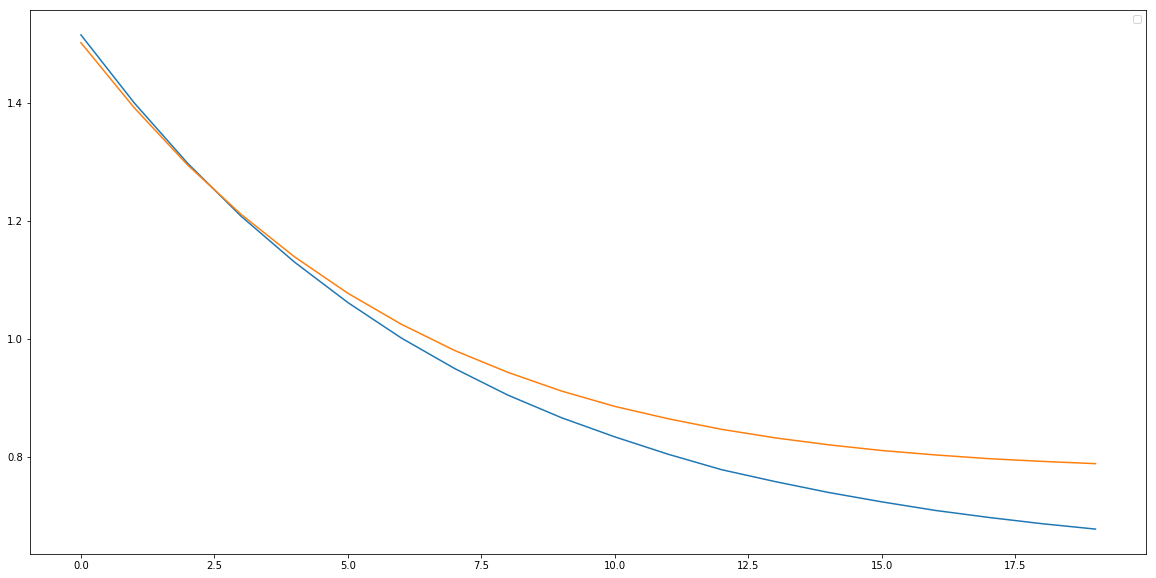

In [142]:
for key in evals_result.keys():
    plt.legend(evals_result.keys())
    plt.plot(evals_result[key]['train']['rmsle']) # blue for trn
    plt.plot(evals_result[key]['eval']['rmsle']) # red for valid

# data slice
3

4 0.7012610665198485, valid loss: 0.7356819327974975

5 0.7011597208347141, valid loss: 0.7576457536626308

6 0.7142544767975981, valid loss: 0.7377355280995211

In [ ]:
# cv_result = xgb.cv(xgb_parms, xdata, num_boost_round=40, nfold=5,
#        metrics={'error'}, seed=0, feval=rmsle_wo_log,
#        callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
# cv_result

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

score = make_scorer(rmsle_wo_log_sk, greater_is_better=False)
param_grid = {
    'min_child_weight':[2],
    'learning_rate':[0.1],
    'max_depth': [3,4],
    'subsample': [0.8], 
    'colsample_bylevel': [0.6], 
    'n_estimators': [32]
}
fit_params = {
    "objective": 'reg:linear',
    "n_jobs": 4,
    "seed":  random.randint(0,1e9),
    "max_delta_step": 0,
    "olsample_bytree": 1,
    "colsample_bylevel": 1,
    "gamma": 0,
    "eg_alpha": 0, 
    "reg_lambda": 1, 
    "scale_pos_weight": 1, 
    "base_score": 0.5, 
    "random_state": 0,
    "booster": 'gbtree',
    "silent": False
}
xgb_gsearch = GridSearchCV(estimator=xgb.XGBRegressor(**fit_params),
                          scoring=score,
                           return_train_score=True,
                          param_grid=param_grid)

In [29]:
res = xgb_gsearch.fit(X=X_train, 
         y=y_train)

0.7829076346293317
0.7913362672260535
0.7916175434686278
0.7871408638049332
0.798612491777245
0.7817214712562407
0.7736135640623134
0.7781766461745124
0.781995999376762
0.775680358354324
0.790805350268948
0.7697910959246055


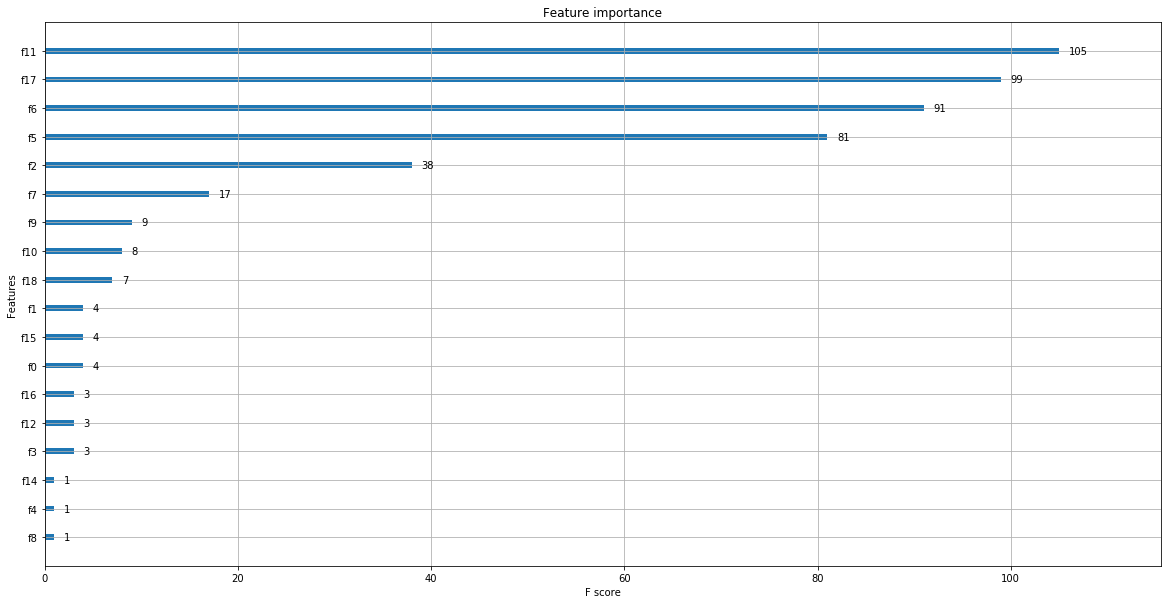

In [41]:
xgb.plot_importance(model)

In [34]:
model = res.best_estimator_

In [53]:
# joblib.dump(clf, "train_model.m")
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1, eg_alpha=0, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=2, missing=None,
       n_estimators=32, n_jobs=4, nthread=None, objective='reg:linear',
       olsample_bytree=1, random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=329200696, silent=False, subsample=0.8)

In [51]:
# model.eval(xdata_val)
pred_trn = model.predict(X_train)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn_loss = rmsle(pred_trn, y_train_orig)
pred_valid = model.predict(X_valid)
pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
valid_loss = rmsle(pred_valid_orig, y_valid_orig)
print('data set: {}/{} train loss: {}, valid loss: {}'.format(data_i+1, len(dat), trn_loss, valid_loss))

data set: 1/1 train loss: 2.6341068693469385, valid loss: 0.8089054777016216


In [20]:
# model.save_model('result/xgboost.h5')
# bst.save_model('0001.model')
# # dump model
# bst.dump_model('dump.raw.txt')
# # dump model with feature map
# bst.dump_model('dump.raw.txt', 'featmap.txt')

# # load
# bst = xgb.Booster({'nthread': 4})  # init model
# bst.load_model('model.bin')  # load data

In [47]:

pred_trn = model.predict(xdata)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn_loss = rmsle(pred_trn_orig, y_train_orig)
evals_result[try_name] = cur_result

array([ 15.78474236,  21.56865311,  16.29379845, ...,  13.20959282,
        14.84749889,  18.34436035], dtype=float32)

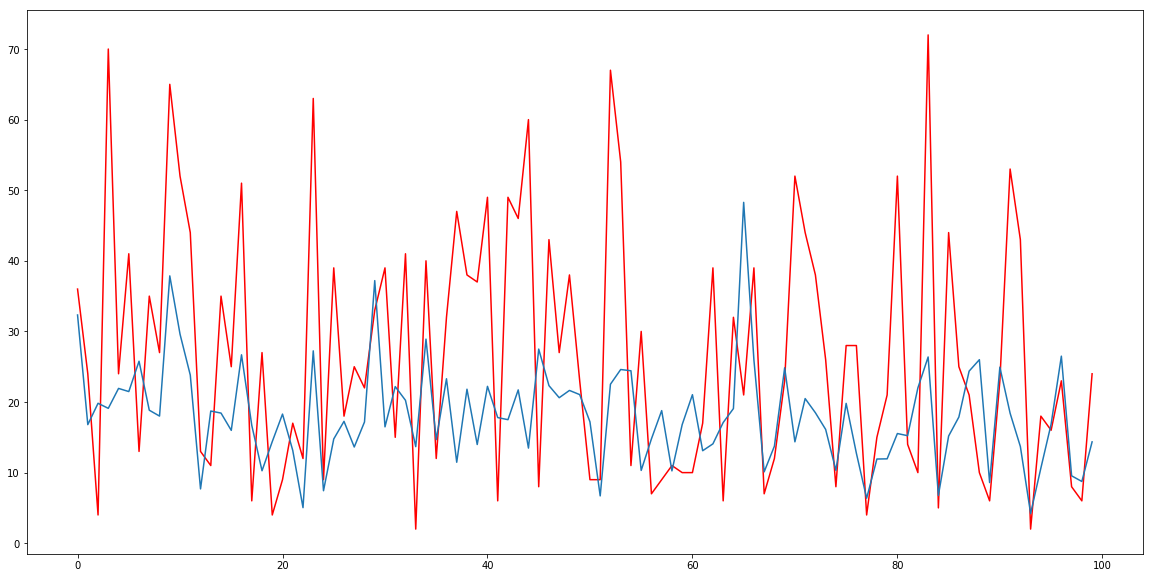

In [119]:
plt.figure(figsize=(20, 10))
plt.plot(y_valid_orig.values[1000:1100], 'r')
plt.plot(pred_valid_orig.flatten()[1000:1100])

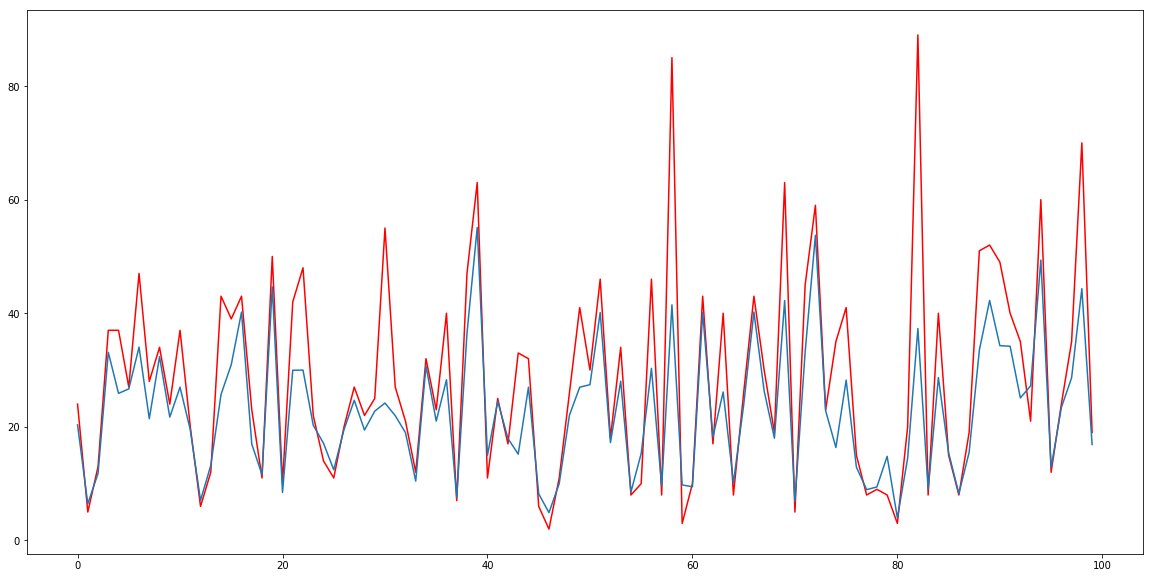

In [118]:
pred_trn = model.predict(xdata)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
plt.figure(figsize=(20, 10))
plt.plot(y_train_orig.values[1000:1100], 'r')
plt.plot(pred_trn_orig.flatten()[1000:1100])


In [143]:
trn.visit_date = pd.to_datetime(trn.visit_date)

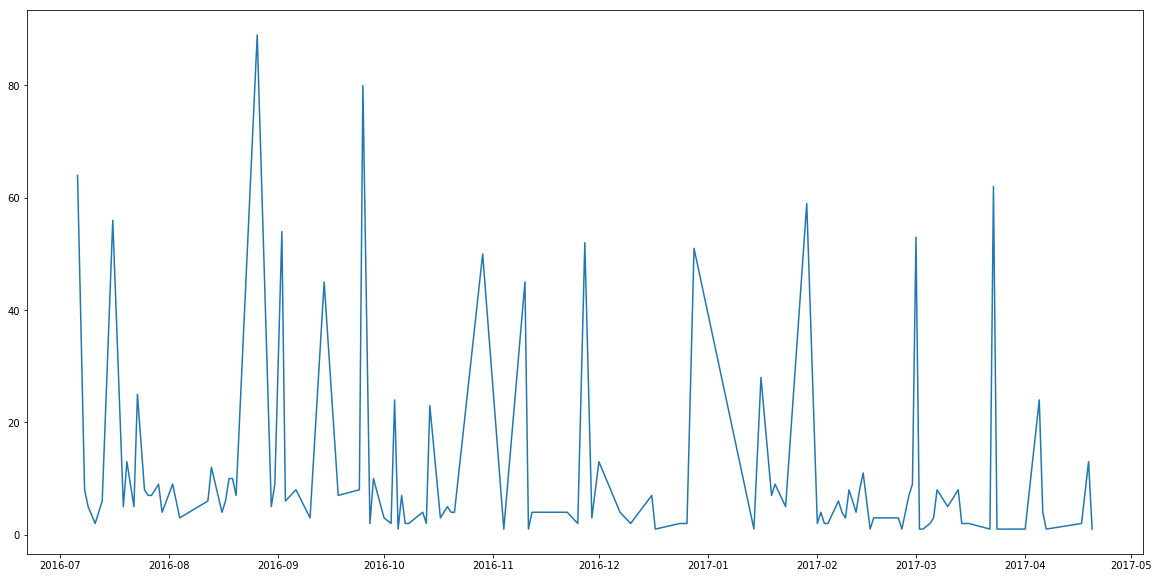

In [150]:
plt.figure(figsize=(20, 10))
plt.plot(trn.visit_date, trn.visitors)

In [182]:
store_info = data['as']
area_cnt = store_info.groupby('air_area_name')['air_store_id'].count().reset_index().rename({'air_store_id': 'store_in_area'}, axis=1)

# Submission

In [21]:
data_dir = r'./data'
test = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(test)
trn_like_test = trn_like_test.assign(visitors = np.round(np.random.rand(len(trn_like_test)) * 100))
test_feas = utils.data2fea(trn_like_test, data_dir, drop_vars=drop_vars)
test_fest_mat = test_feas['sk_fea']


all_vars = feas['all_vars']
test_data = xgboost.DMatrix(test_fest_mat, feature_names=all_vars)

preded_test = model.predict(test_data)
pred_test_orig = utils.log_max_inv(preded_test, max_log_y)
test.visitors = pred_test_orig
test.to_csv('result/xgb.csv', index=False)

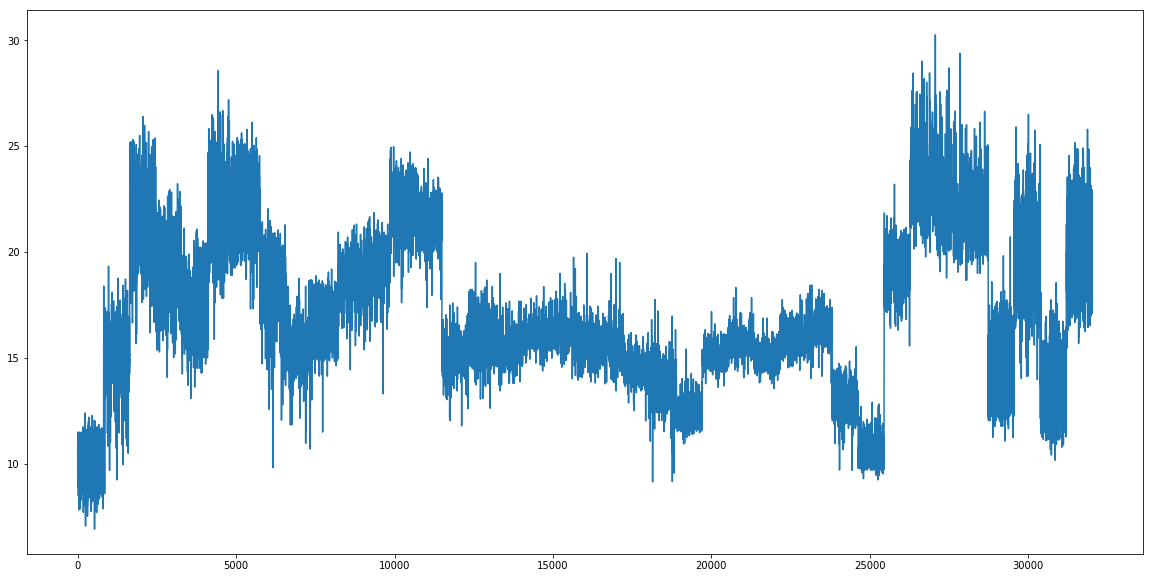

In [26]:
test.visitors.plot()

In [ ]:
test